# 1. Introduction


The purpose of this notebook is to create Convolutionnal Neural Network in Pytorch to colorize anime faces from the dataset Anime Faces by Mckinsey666. In order to this, we will use a similar model than the U-Net by Ronneberger and al : https://arxiv.org/abs/1505.04597.


This network has two symmetrical parts. The _contracting path_ which is a typical convolutionnal neural network reducing the size of images and increasing the number of feature maps with convolutions and max pooling. This is followed by the _expansive path_ which uses up convolutionnal layers (transposed convolutionnal layers) and upsampling to do the opposite.


The particularity of the U-Net is that it concatenates the data from the first path into the second symmetrically. We will not do such things.  
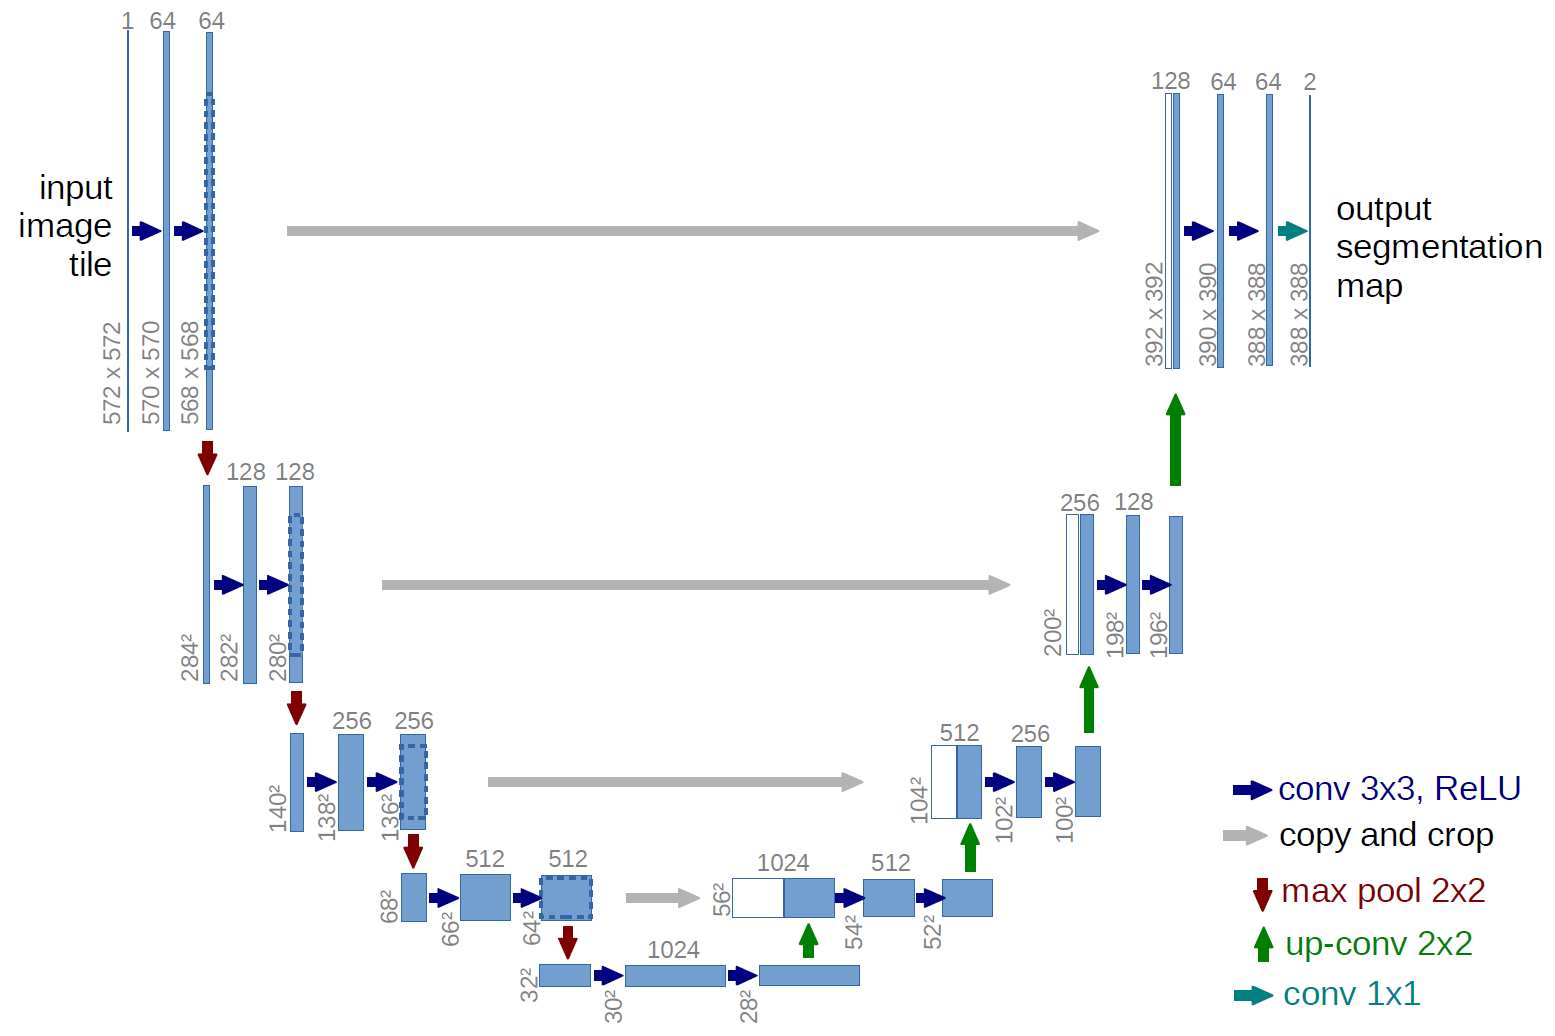


As you can see, the up-con 2x2 are supposed to _double_ the size of the images. Taking the formula of the relation between input and output shape for an upconv layer : <br/>
$out = (in − 1)s - 2p + d(k-1) + padd + 1
$with $d=1$ being the dilation ; $padd=0$ being the padding; $k=2$ being the kernel size <br/>
We get $s=2$. That's why we have strides=(2,2).


_Note : I recommend you to use a GPU for faster results as we work on images._


## 1.1. Imports


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## 1.2. Classes and look at the dataset


In [5]:
class ColorizationDataset(Dataset):
    def __init__(self, image_size, cuda=False):
        self.image_size = image_size
        self.cuda = cuda

    def __len__(self):
        return len(os.listdir('./data/data/'))

    def __getitem__(self, idx):
        with Image.open(f'./data/data/{str(idx+1)}.png') as image:
            img = image.copy()

        compose_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        Y = compose_transforms(img)
        X = (Y[0] * 0.299 + Y[1] * 0.587 + Y[2] * 0.114).reshape(1, 64, 64)
        if self.cuda:
            X = X.to(device)
            Y = Y.to(device)
        return X, Y


In [6]:
dset = ColorizationDataset(64)
batch_size = 32
dataset, _ = torch.utils.data.random_split(
    dset, [int(len(dset)/4), len(dset)-int(len(dset)/4)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
def to_numpy_image(img):
    img = img.cpu()
    return img.detach().transpose(0, 1).transpose(1, 2).numpy()


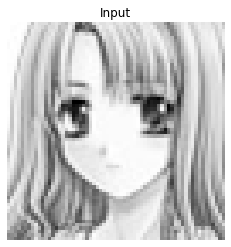

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


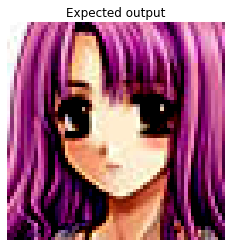

In [8]:
x, y = dset[1]

plt.imshow(x.reshape(64, 64, 1), cmap='Greys_r')
plt.title("Input")
plt.axis('off')
plt.show()
plt.title("Expected output")
plt.axis('off')
plt.imshow(to_numpy_image(y))
plt.show()


# 2. Typical CNN


## 2.1. Training the model


In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(64, 64, 1)))

model.add(tf.keras.layers.Convolution2D(
    64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Convolution2D(
    64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=None, padding='same'))

model.add(tf.keras.layers.Convolution2D(
    32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Convolution2D(
    32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=None, padding='same'))

model.add(tf.keras.layers.Convolution2D(
    16, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Convolution2D(
    16, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=None, padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(12288, activation='relu'))  # 64*64*3=12288

model.summary()

model.compile(loss='MSE', optimizer='adam', metrics=["accuracy"])


In [ ]:
X_train = [dset[i][0].numpy().reshape(64, 64, 1)
           for i in range(int(len(dset)/2))]
Y_train = [dset[i][1].numpy().reshape(12288) for i in range(int(len(dset)/2))]
X_valid = [dset[i][0].numpy().reshape(64, 64, 1)
           for i in range(int(len(dset)/2)+1, len(dset)-4)]
Y_valid = [dset[i][1].numpy().reshape(12288)
           for i in range(int(len(dset)/2)+1, len(dset)-4)]


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

history = model.fit(X_train, Y_train, batch_size=64,
                    epochs=10, validation_data=(X_valid, Y_valid))


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## 2.2. Simple CNN results


In [ ]:
for i in range(1, 4):
    x, y = dset.__getitem__(len(dset)-i)
    x = x.numpy().reshape(-1, 64, 64, 1)
    plt.figure(figsize=(10, 10))
    plt.subplot(141)
    plt.axis('off')
    if i == 1:
        plt.title('Input')
    plt.imshow(x.reshape(64, 64, 1), cmap='Greys_r')
    y_pred = torch.from_numpy(model.predict(x))
    aff = (y_pred.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy()
    plt.subplot(142)
    plt.imshow(aff)
    if i == 1:
        plt.title('Output')
    plt.axis('off')
    plt.subplot(143)
    if i == 1:
        plt.title('Expected output')
    plt.axis('off')
    plt.imshow((y.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy())
    plt.show()


# 3. U-NET Architecture with TensorFlow


## 3.1. Training the model


In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(64, 64, 1)))

# contracting path
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

# expansive path
model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
    256, (2, 2), strides=(2, 2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Convolution2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(64, (3, 3)))
model.add(tf.keras.layers.Convolution2D(64, (3, 3)))
model.add(tf.keras.layers.Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(3, (1, 1), padding='same'))


model.summary()

model.compile(loss='MSE', optimizer='adam', metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                    

In [14]:
import visualkeras
from PIL import ImageFont

# using comic sans is strictly prohibited!
font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model , legend=True, font=font,draw_shapes=2,padding_vertical=75,padding_left=150,draw_reversed=True).show()


In [29]:
def show_layer_model(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.output_shape)


show_layer_model(model)


0 conv2d_11 (None, 62, 62, 64)
1 conv2d_12 (None, 60, 60, 64)
2 max_pooling2d_2 (None, 30, 30, 64)
3 conv2d_13 (None, 28, 28, 128)
4 conv2d_14 (None, 26, 26, 128)
5 max_pooling2d_3 (None, 13, 13, 128)
6 conv2d_15 (None, 11, 11, 256)
7 conv2d_16 (None, 9, 9, 256)
8 conv2d_transpose_3 (None, 18, 18, 256)
9 conv2d_17 (None, 18, 18, 128)
10 conv2d_18 (None, 18, 18, 128)
11 conv2d_transpose_4 (None, 36, 36, 128)
12 conv2d_19 (None, 34, 34, 64)
13 conv2d_20 (None, 32, 32, 64)
14 conv2d_transpose_5 (None, 64, 64, 64)
15 conv2d_21 (None, 64, 64, 3)


In [ ]:
X_train = [dset[i][0].numpy().reshape(64, 64, 1)
           for i in range(int(3*len(dset)/4))]
Y_train = [dset[i][1].numpy().reshape(64, 64, 3)
           for i in range(int(3*len(dset)/4))]
X_valid = [dset[i][0].numpy().reshape(64, 64, 1)
           for i in range(int(3*len(dset)/4)+1, len(dset)-4)]
Y_valid = [dset[i][1].numpy().reshape(64, 64, 3)
           for i in range(int(3*len(dset)/4)+1, len(dset)-4)]


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

history = model.fit(X_train, Y_train, batch_size=64,
                    epochs=30, validation_data=(X_valid, Y_valid))


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## 3.2. Results


In [ ]:
for i in range(1, 4):
    x, y = dset.__getitem__(len(dset)-i)
    x = x.numpy().reshape(-1, 64, 64, 1)
    plt.figure(figsize=(10, 10))
    plt.subplot(141)
    plt.axis('off')
    if i == 1:
        plt.title('Input')
    plt.imshow(x.reshape(64, 64, 1), cmap='Greys_r')
    y_pred = torch.from_numpy(model.predict(x))
    aff = (y_pred.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy()
    plt.subplot(142)
    plt.imshow(aff)
    if i == 1:
        plt.title('Output')
    plt.axis('off')
    plt.subplot(143)
    if i == 1:
        plt.title('Expected Output')
    plt.axis('off')
    plt.imshow((y.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy())
    plt.show()


# 4. Different U-NET Architecture Pytorch


## 4.1. Training the model


In [ ]:
dset = ColorizationDataset(64, cuda=True)  # USE THE GPU
dataset, _ = torch.utils.data.random_split(
    dset, [int(len(dset)/4), len(dset)-int(len(dset)/4)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class Colorizer(nn.Module):

    def __init__(self):
        super(Colorizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 256, 3, 2, 1)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 2, dilation=2)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 2, dilation=2)
        self.conv6 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.conv7 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv8 = nn.ConvTranspose2d(64, 3, 3, 2, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(64)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        y = self.bn1(self.leakyrelu(self.conv1(x)))
        y = self.bn2(self.leakyrelu(self.conv2(y)))
        y = self.bn3(self.leakyrelu(self.conv3(y)))
        y = self.bn4(self.leakyrelu(self.conv4(y)))
        y = self.bn5(self.leakyrelu(self.conv5(y)))
        y = self.bn6(self.leakyrelu(self.conv6(y)))
        y = self.bn7(self.leakyrelu(self.conv7(y)))
        y = self.tanh(self.conv8(y))
        return y


In [ ]:
model = Colorizer()

if torch.cuda.is_available():
    model.to(device)


In [ ]:
num_epochs = 5  # RAM eater
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

history = []
for epoch in range(num_epochs):
    for x, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        history.append(loss)
        loss.backward()
        optimizer.step()


In [ ]:
plt.plot(history)
plt.title('Loss')
plt.show()


## 4.2. Pytorch model results


In [ ]:
for i in range(3):
    rng = np.random.randint(len(dset))
    img_gray, img_true = dset[rng]
    img_pred = model(img_gray.reshape(1, 1, 64, 64))
    img_pred = to_numpy_image(img_pred.reshape(3, 64, 64))
    plt.figure(figsize=(10, 10))
    plt.subplot(141)
    if i == 0:
        plt.title('Input')
    plt.axis('off')
    plt.imshow(1-to_numpy_image(img_gray).reshape((64, 64)), cmap='Greys')
    plt.subplot(142)
    if i == 0:
        plt.title('Output')
    plt.axis('off')
    plt.imshow(img_pred)
    plt.subplot(143)
    if i == 0:
        plt.title('Expected Output')
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    plt.show()


# 5. Conclusion


It seems that the colorization isn't really convincing, according to the plot of the loss more epochs couldn't do the trick. Furthermore, we can see artefacts on some of the generated images. To me, the main reason fot this not working properly is that I'm not using the good architecture. In addition, the manga characters have a wide variety of hair colors. So the program has a better chance of reducing its loss by taking an "average" color that appears to be brown.


Also, it seems that the network has better chance to reduce its loss by fully coloring eyes in black.


_Extended work direction :_ Using a subclass of Model rather than using Sequential would have allowed to use the concatenation layers in order to avoid the blurry images in the tensorflow model.
